In [2]:
from subprocess import call
import os
import glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from shutil import copyfile, move, copy, copytree, rmtree
from distutils.dir_util import copy_tree
from IPython.display import clear_output
from tempfile import mkstemp
from os import fdopen, remove

from ema_workbench import (RealParameter, IntegerParameter, BooleanParameter, ScalarOutcome, ArrayOutcome, Constant, Model, MultiprocessingEvaluator, Policy, perform_experiments, ema_logging )
from ema_workbench import (save_results, load_results)

from functools import partial
from multiprocessing import Pool, Lock
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

import matplotlib.pyplot as plt
from scipy import stats

from numpy.lib import recfunctions as rf

C:\Users\Admin_2\Anaconda3\lib\importlib\_bootstrap.py:219: ImportWarning: can't resolve package from __spec__ or __package__, falling back on __name__ and __path__
  return f(*args, **kwds)


In [3]:
import io
import math
from io import StringIO

import matplotlib.pyplot as plt
import matplotlib.image as mpimg

import numpy as np
import pandas as pd

from sklearn import tree


from ema_workbench.util.ema_exceptions import EMAError
from pygments.unistring import cats

import graphviz

import os

os.environ['PATH'] = os.environ['PATH']+';'+os.environ['CONDA_PREFIX']+r"\Library\bin\graphviz"

C:\Users\Admin_2\Anaconda3\lib\importlib\_bootstrap.py:219: ImportWarning: can't resolve package from __spec__ or __package__, falling back on __name__ and __path__
  return f(*args, **kwds)
C:\Users\Admin_2\Anaconda3\lib\importlib\_bootstrap.py:219: ImportWarning: can't resolve package from __spec__ or __package__, falling back on __name__ and __path__
  return f(*args, **kwds)


In [4]:
os.chdir("C:/Users/Admin_2/Documents/Thesis/LUS/DeltaScenarios_TUdelft1")
notebook_dir = os.getcwd()



In [3]:
def geodmsrun(config, tree, geodms_dir = r"C:/Program Files/ObjectVision/GeoDms7212"): #change this to your GeoDms directory
    
    #change working directory
    notebook_dir = os.getcwd()
    os.chdir(geodms_dir)
    assert os.path.isdir(geodms_dir)
    
    print(os.getcwd())
    
    #run the geodms
    arg_exe = ['GeoDmsRun.exe', config, tree]
    call(arg_exe)
    
    #change back the working directory
    os.chdir(notebook_dir)
    print(os.getcwd())
    
def find_line(file_path, pattern):
    #Create temp file
    lines = []
    fh, abs_path = mkstemp()
    with fdopen(fh,'w') as new_file:
        with open(file_path) as old_file:
            for line in old_file:
                if pattern in line:
                    lines.append(line)
    return lines

#Function which will determine the new line containing the new value:
def new_line(beginline, line, new_val, endline):
    newline = beginline + str(new_val) + line[line.find(endline):]
    return newline

#Function which actually replaces the value of demand
def replace_line(beginline, file_path, pattern, new_val, endline):
    #Create temp file
    fh, abs_path = mkstemp()
    with fdopen(fh,'w') as new_file:
        with open(file_path) as old_file:
            for line in old_file:
                if line==pattern:
                    subst = new_line(beginline, line, new_val, endline)
                    new_file.write(line.replace(pattern, subst))
                else:
                    new_file.write(line)
    #Remove original file
    remove(file_path)
    #Move new file
    move(abs_path, file_path)


## Changing the land use claims

### Residential claim parameters
Residential claim
To be able to switch between de input of housing demand for each scenario, a few steps are taken:

Four files are created in the source data (SD/claims), which each contain different housing demand generated by the TigrisXL model. These files are:

- TigrisXL (hoog_spreiding)
- TigrisXL2 (hoog_concentratie)
- TigrisXL3 (laag_spreiding)
- TigrisXL4 (laag_concentratie)

Within these four files, the file which contains the housing demand per year is, in all four TigrisXL files, named "hoog_spreiding". This is done because we use the STOOM scenario as our default model run, which will only recognize files named "hoog_spreiding".

Next, the actual housing demand in Ha is calculated using a density factor (DensityFactor) and an "inbreidingsfractie". So for each scenario, the corresponding values of these factors are:

hoog_spreiding: DensityFactor = 1.0, Inbreidingsfractie = 0.25
hoog_concentratie: DensityFactor = 1.33, Inbreidingsfractie = 0.75
laag_spreiding: DensityFactor = 1.0, Inbreidingsfractie = 0.25
laag_concentratie: DensityFactor = 1.33, Inbreidingsfractie = 0.75
So, to change the housing claim input, we will run with the different TigrisXL files and using different density factors and inbreidingsfractie.

In [4]:
def changeresidentialclaim(TigrisXLfile, inbreiding, Density):
    if TigrisXLfile == 1:
        TLXfilename = 'TigrisXL'
    elif TigrisXLfile == 2:
        TLXfilename = 'TigrisXL2'
    elif TigrisXLfile == 3:
        TLXfilename = 'TigrisXL3'
    else:
        TLXfilename = 'TigrisXL4'
    #Change TigrisXL file in claimswonen.dms and claimspopulation.dms
    claimswonendms = notebook_dir+'/PD/cfg/stam/Templates/ClaimsWonen.dms'
    claimspopulationdms = notebook_dir+'/PD/cfg/stam/Templates/ClaimsPopulation.dms'
    houseclaimsearch = '%SourceDataProjDir%/Claims/Tigris'
    housebeginline = '\t\t:\tStorageName = "=\'%SourceDataProjDir%/Claims/'
    houseendline = '/\'+ ClaimSrcDir + \'/landuse/landuse.dat\'"\n'
    popbeginline = '\t\t,\tStorageName = "=\'%SourceDataProjDir%/Claims/'
    popendline ='/\'+ dirname + \'/\' + jaar + \'/segs/segs.dbf\'"\n'
    
    houseline = find_line(claimswonendms,houseclaimsearch)[0]
    popline = find_line(claimspopulationdms, houseclaimsearch)[0]
    
    
    #Change densityfactor and Infringement fraction in scenarios.dms
    if inbreiding == True:
        inbreidingvalue = 0.25
    else:
        inbreidingvalue = 0.75
    
    scenariosdms = notebook_dir+'/PD/cfg/stam/Classifications/Scenarios.dms'
    
    inbreidingclaimsearch = 'attribute<float32> Inbreidingsfractie'
    inbreidingbeginline = '\t\t\tattribute<float32> Inbreidingsfractie : ['
    inbreidingendline = ', 0.75]'
    
    inbreidingline = find_line(scenariosdms, inbreidingclaimsearch)[0]
    replace_line(inbreidingbeginline, scenariosdms, inbreidingline, inbreidingvalue, inbreidingendline)
    
    if Density == True:
        densityvalue = 1.33
    else:
        densityvalue = 1.0
    
    densclaimsearch = 'attribute<float32> DensityFactor'
    densline = find_line(scenariosdms, densclaimsearch)[0]
    densbeginline = '\t\t\tattribute<float32> DensityFactor: ['
    densendline = ', 1.33]'
    
    
    replace_line(housebeginline, claimswonendms, houseline, TLXfilename, houseendline)
    replace_line(popbeginline, claimspopulationdms, popline, TLXfilename, popendline)
    replace_line(densbeginline, scenariosdms, densline, densityvalue, densendline)
    


### Industry & commerce claim parameters
To change the work claim, a few steps have to be taken: 
- Same as for housing claim, the four TigrisXL files are used and can be changed. 
- Next, with this function you can also change the location type preference (LVQ).Lastly, with this function you can also change the terraincoefficient (TYQ). LVQ and TYQ go together and are not to change seperately. For this reason, both variable are determined with "Claimfile". This variable, Claimfile, will determing which file the LVQ and TYQ are read from. 

TigrisXL files (TigrisXLfile):
- See Residential claim 

Claim files (Claimfilename):
- Claims (True) = Hoog scenario
- Claims2 (False) = Laag scenario

In [5]:
def changeworkclaim(TigrisXLfile, Claimfile):
    if TigrisXLfile == 1:
        TLXfilename = 'TigrisXL'
    elif TigrisXLfile == 2:
        TLXfilename = 'TigrisXL2'
    elif TigrisXLfile == 3:
        TLXfilename = 'TigrisXL3'
    else:
        TLXfilename = 'TigrisXL4'
    #Change work claim source data
    claimswerkendms = notebook_dir+'/PD/cfg/stam/Templates/ClaimsWerken.dms'
    workclaimsearch = '%SourceDataProjDir%/Claims/Tigris'
    workline = find_line(claimswerkendms, workclaimsearch)[0]
    workbeginline = '\t\t:\tStorageName = "=\'%SourceDataProjDir%/Claims/'
    workendline = '/\'+ dirname + \'/\' + jaar + \'/labour/labour.dat\'"\n'
    replace_line( workbeginline, claimswerkendms, workline, TLXfilename, workendline)
   
    if Claimfile == True:
        Claimfilename = 'Claims'
    else:
        Claimfilename = 'Claims2'

    #Change LVQ & TYQ files 
    LVQreadsearch = '%SourceDataProjDir%/Claims'
    LVQline = find_line(claimswerkendms,LVQreadsearch )[1]
    LVQbeginline = '\t\t:\tStorageName = "=\'%SourceDataProjDir%/'
    LVQendline = '/\'+ dirname + \'/\'+ jaar + \'/\'+ filename +\'\'"\n'
    
    
    TYQline = find_line(claimswerkendms,LVQreadsearch )[2]
    TYQbeginline = '\t\t:\tStorageName = "=\'%SourceDataProjDir%/'
    TYQendline = '/\'+ dirname + \'/\'+ jaar + \'/\'+ filename +\'\'"\n'
    
    
    replace_line( TYQbeginline, claimswerkendms,  TYQline, Claimfilename, TYQendline)
    replace_line( workbeginline, claimswerkendms, workline, TLXfilename, workendline)
    replace_line( LVQbeginline, claimswerkendms, LVQline, Claimfilename, LVQendline)

### Nature claim parameters
Nature claim values (natureclaim):
- value 1 = 106000 (DRUK)
- value 2 = 75000 (STOOM)
- value 3 = 5000 (WARM & RUST)

In [6]:
def changenatureclaim(natureclaim):
    if natureclaim == 1:
        natureha = 106000
    elif natureclaim == 2:
        natureha = 75000
    else: 
        natureha = 5000
    
    Naturedms = notebook_dir+'/PD/cfg/stam/Claims/TotalenInBron.dms' #change to location file
    Natureclaimsearch = 'attribute<claimHa> STOOM  := Nl/ID == 1[uint8] ?' #line of code it will look for to find where parameter should be changed
    naturebeginline = str('\t\t\t\tattribute<claimHa> STOOM  := Nl/ID == 1[uint8] ?  ') #how the line should look before the parameter value
    natureendline = str('[claimHa]') # how the line should look after the parameter value
    natureline = find_line(Naturedms, Natureclaimsearch)[0]
    
    
    replace_line(naturebeginline, Naturedms, natureline, natureha, natureendline ) #replaces the line

### Recreation claim parameters
Recreation claim (recvalue):
- True = GE (hoog scenario)
- False = RC (laag scenario) 

In [7]:
def changerecreationclaim(recvalue):
    if recvalue == True:
        GEorRC = 'GE'
    else:
        GEorRC = 'RC'
    recreationdms = notebook_dir+'/PD/cfg/stam/Claims/TotalenInBron/Verblijfsrecreatie.dms'
    recreationclaimsearch = '%SourceDataProjDir%/Claims/Ruimte/verblijfsrec_'
    recline = find_line(recreationdms, recreationclaimsearch)[0]
    recbeginline = '        ", \'NaarCases(\'+quote(\'%SourceDataProjDir%/Claims/Ruimte/verblijfsrec_'
    recendline = '_provincie'
    
    
    replace_line(recbeginline, recreationdms, recline, GEorRC, recendline)

### Agriculture claim parameters
For all agrclaim values:
- True = hoog scenario
- False = laag scenario


In [8]:
def changeagricultureclaim(agrclaim):
    
    agrdms = notebook_dir+'/PD/cfg/stam/Claims/TotalenInBron/AgrIntens.dms'
    
    if agrclaim == True:
        glastuinbouwdecrease = 0.1
        opengroentenha = 27100
        bloembollenha = 23600
        boomgaardha = 17300
        boomteeltha = 17100
    else:
        glastuinbouwdecrease  = 0.3
        opengroentenha = 22100
        bloembollenha = 21200
        boomgaardha = 15400
        boomteeltha = 15400
        
    agrclaimsearch5 = 'attribute<ggHa> agr_glastuinbouw'
    agrbeginline5 = str('\t\t\tattribute<ggHa> agr_glastuinbouw (NL):= NL/ID == 1[uint8] ? InBasisjaar/In2011/agr_glastuinbouw + -')
    agrendline5 = '[float32]'
    agrline5 = find_line(agrdms, agrclaimsearch5)[1]
    
        
    agrclaimsearch1 = 'attribute<ggHa> agr_OpenGroenten (NL):= NL/ID == 1[uint8] ?'
    agrbeginline1 = str('\t\t\tattribute<ggHa> agr_OpenGroenten (NL):= NL/ID == 1[uint8] ? ')
    agrendline = '[ggHa]'
    agrline1 = find_line(agrdms, agrclaimsearch1)[1]
    
    
    agrclaimsearch2 = 'attribute<ggHa> agr_bloembollen'
    agrbeginline2 = str('\t\t\tattribute<ggHa> agr_bloembollen  (NL):= NL/ID == 1[uint8] ? ')
    agrline2 = find_line(agrdms, agrclaimsearch2)[1]
    
    
    
    agrclaimsearch3 = 'attribute<ggHa> agr_boomgaard'
    agrbeginline3 = str('\t\t\tattribute<ggHa> agr_boomgaard    (NL):= NL/ID == 1[uint8] ? ')
    agrline3 = find_line(agrdms, agrclaimsearch3)[1]
    
    
    
    agrclaimsearch4 = 'attribute<ggHa> agr_boomteelt'
    agrbeginline4 = str('\t\t\tattribute<ggHa> agr_boomteelt    (NL):= NL/ID == 1[uint8] ? ')
    agrline4 = find_line(agrdms, agrclaimsearch4)[1]
    
    replace_line(agrbeginline1, agrdms, agrline1, opengroentenha, agrendline)
    replace_line(agrbeginline5, agrdms, agrline5, glastuinbouwdecrease, agrendline5)
    replace_line(agrbeginline4, agrdms, agrline4, boomteeltha, agrendline)
    replace_line(agrbeginline2, agrdms, agrline2, bloembollenha, agrendline)
    replace_line(agrbeginline3, agrdms, agrline3, boomgaardha, agrendline)
    
    

## Changing the suitability

In [9]:
def naturesuitability(valuenaturelocation, policyweightnature, pumping):
    #changing the location factor value 
    if valuenaturelocation == 1:
        locationweight = '0.0'
        scenario1 = 'STOOM,'
        scenario2 = 'DRUK'
    elif valuenaturelocation == 2: 
        locationweight = 'woongebied/locatie'
        scenario1 = 'STOOM,'
        scenario2 = 'DRUK'
    else:
        locationweight = '0.0'
        scenario1 = 'DRUK,'
        scenario2 = 'STOOM'
        
    suitabilitynaturedms = notebook_dir+'/PD/cfg/stam/Templates/geschiktheid/natuur.dms'

    #changing the scenario:
    scenario1search = 'Scenario == /ScenarioUnit/V/'
    scenario1line = find_line(suitabilitynaturedms,scenario1search )[0]
    scenario1beginline = '\t\t\t\tScenario == /ScenarioUnit/V/'
    scenario1endline = '\n'
   

    scenario2search = 'Scenario == /ScenarioUnit/V/'
    scenario2line = find_line(suitabilitynaturedms,scenario1search )[1]
    scenario2beginline = '\t\t\t\tScenario == /ScenarioUnit/V/'
    scenario2endline =  ' || Scenario == /ScenarioUnit/V/PARIJS,\n'
    
    
    #changing location factor value weight:
    locationweightsearch = 'value('
    locationweightline = find_line(suitabilitynaturedms,locationweightsearch )[3]
    locationweightbeginline = '\t\t\t\tvalue('
    locationweightendline = ', Eur_M2_jaarlijks)'
   
    
    #changing the policy stimuli weight: 
    if policyweightnature == True:
        policyweightnaturevalue = 5.0
    else:
        policyweightnaturevalue = 0.0
    
    policyweightsearch = 'value('
    policyline = find_line(suitabilitynaturedms,policyweightsearch)[7]
    policybeginline = '\t\t\t\tvalue('
    policyendline = ', Eur_M2_jaarlijks)\n'
   
    
    #changing fysical policy model structure:
    if pumping == True:
        pumppolicy = 'Bronnen/endstate/PotentieNat/PotentieNatPercentage'
    else:
        pumppolicy = 'Omgeving/natuurlandschap/NatuurAdaptatie/potentie_nathuidig'
        
    #Changing the pump policy: 
    pumppolicysearch = '//omdat in dit scenario wel wordt gepompt'
    pumppolicyline = find_line(suitabilitynaturedms,pumppolicysearch)[0]
    pumppolicybeginline = '\t\t\t\t\t\t'
    pumppolicyendline =  '//omdat in dit scenario wel wordt gepompt bij bodemdaling\n'
    
    replace_line(policybeginline, suitabilitynaturedms, policyline, policyweightnaturevalue,  policyendline)
    replace_line( locationweightbeginline, suitabilitynaturedms, locationweightline, locationweight, locationweightendline)
    replace_line( scenario2beginline, suitabilitynaturedms, scenario2line, scenario2, scenario2endline)
    replace_line( scenario1beginline, suitabilitynaturedms, scenario1line, scenario1, scenario1endline)
    replace_line( pumppolicybeginline, suitabilitynaturedms, pumppolicyline, pumppolicy, pumppolicyendline)

    

In [10]:
def changenaturepolicy(naturepolicymap, restrictionnatureweight):
    if naturepolicymap == 1:
        naturepolicy = 'RobuustVitaal_natuur' #or ehs_uitgekleed or functionele_natuur
    elif naturepolicymap == 2:
        naturepolicy = 'ehs_uitgekleed'
    else:
        naturepolicy = 'functionele_natuur'
    
    #change policy maps nature
    suitabilitynaturedms = notebook_dir+'/PD/cfg/stam/Templates/geschiktheid/natuur.dms'
    policynaturesearch = '(Beleid/NatuurLandschap/'
    naturepolicyline = find_line(suitabilitynaturedms,policynaturesearch)[0]
    naturepolicybeginline = '\t\t\t\t\t(Beleid/NatuurLandschap/'
    naturepolicyendline =  ' >= 0[Classifications/Beleid/ndt_multi]\n'
   
    
    policyrestrictionsdms = notebook_dir+'/PD/cfg/stam/Templates/geschiktheid/beleid_restricties.dms'
    restrictionnaturepolicysearch = '"&& Beleid/NatuurLandschap/'
    restrnaturepolicyline = find_line(policyrestrictionsdms,restrictionnaturepolicysearch)[0]
    restrnaturepolicybeginline = '\t\t\t\t"&& Beleid/NatuurLandschap/'
    restrnaturepolicyendline =  ' >= 0[Classifications/Beleid/ndt_multi]"\n'
   
    
    #change wieght policy restriction
    if restrictionnatureweight == True:
        restrictionnatureweightvalue = 30.0
    else:
        restrictionnatureweightvalue = 0.0
        
    restrictionnaturesearch = '",  value('
    restrictionnatureline = find_line(policyrestrictionsdms,restrictionnaturesearch)[2]
    restrictionnaturebeginline = '\t\t\t\t",  value('
    restrictionnatureendline = ', Eur_M2_jaarlijks)"\n'
    
    
    replace_line(naturepolicybeginline, suitabilitynaturedms, naturepolicyline, naturepolicy,  naturepolicyendline)
    replace_line(restrictionnaturebeginline, policyrestrictionsdms, restrictionnatureline, restrictionnatureweightvalue,  restrictionnatureendline)
    replace_line(restrnaturepolicybeginline, policyrestrictionsdms, restrnaturepolicyline, naturepolicy, restrnaturepolicyendline)

In [11]:
def changehousingsuitability(spreidingratio):
    if spreidingratio == True: 
        ratio = 0.5
    else:
        ratio = 1.0
    #Changing the spread ratio:
    housingsuitabilitydms = notebook_dir+'/PD/cfg/stam/Templates/geschiktheid/woongebied.dms'
    spreidingratiosearch = 'iif(Spreiding'
    spreidingratioline = find_line(housingsuitabilitydms,spreidingratiosearch)[0]
    spreidingratiobeginline = '\t\t* iif(Spreiding, value('
    spreidingratioendline = ', Ratio), value(1.0, Ratio))\n'
    
    
    replace_line( spreidingratiobeginline, housingsuitabilitydms,  spreidingratioline, ratio, spreidingratioendline)   

## Defining the model

In [12]:
def LUS_model(TigrisXLfile, inbreiding, Density, Claimfile, natureclaim, recvalue, restrictionnatureweight, naturepolicymap, policyweightnature, spreidingratio, valuenaturelocation, pumping, agrclaim):
    
    changeresidentialclaim(TigrisXLfile, inbreiding, Density)
    changeworkclaim(TigrisXLfile, Claimfile)
    changenatureclaim(natureclaim)
    changerecreationclaim(recvalue)
    changeagricultureclaim(agrclaim)
    
    naturesuitability(valuenaturelocation, policyweightnature, pumping)
    changehousingsuitability(spreidingratio)
    changenaturepolicy(naturepolicymap, restrictionnatureweight)
  
    
    
    #runmodel
    
    config = notebook_dir+'/PD/cfg/stam.dms'
    tree = '/EndResults/PerScenTimeUnit/STOOM_Y2012_Y2050/Run1'

    geodmsrun(config, tree)
    
    
    src = notebook_dir+'/PD/cfg/stam/results/run1.asc'
    
    lusmap = np.loadtxt(src, skiprows=6)
    
    dummy = np.max(lusmap)
    
    return lusmap, dummy

### Experimental and output set-up

In [13]:
ema_logging.log_to_stderr(ema_logging.INFO)
    
LUSmodel = Model('LUS', function=LUS_model)
    
LUSmodel.uncertainties = [  BooleanParameter('agrclaim'),
                            IntegerParameter('TigrisXLfile', 1, 4),
                            BooleanParameter('inbreiding'),
                            BooleanParameter('Density'),
                            BooleanParameter('Claimfile'),
                            IntegerParameter('natureclaim', 1, 3),
                            BooleanParameter('recvalue'),
                            BooleanParameter('restrictionnatureweight'),
                            IntegerParameter('naturepolicymap', 1, 3),
                            BooleanParameter('policyweightnature'),
                            BooleanParameter('spreidingratio'),
                            IntegerParameter('valuenaturelocation', 1, 3),
                            BooleanParameter('pumping')]
                                    
                               
                             

LUSmodel.outcomes = [ArrayOutcome('lusmap')]
    
n_scenarios = 10
    

In [15]:
results = perform_experiments(LUSmodel, n_scenarios)
    
save_results(results, "02_6_10.tar.gz")

[MainProcess/INFO] performing 10 scenarios * 1 policies * 1 model(s) = 10 experiments
[MainProcess/INFO] performing experiments sequentially


C:\Program Files\ObjectVision\GeoDms7212
C:\Users\Admin_2\Documents\Thesis\LUS\DeltaScenarios_TUdelft1


[MainProcess/INFO] 1 cases completed


C:\Program Files\ObjectVision\GeoDms7212
C:\Users\Admin_2\Documents\Thesis\LUS\DeltaScenarios_TUdelft1


[MainProcess/INFO] 2 cases completed


C:\Program Files\ObjectVision\GeoDms7212
C:\Users\Admin_2\Documents\Thesis\LUS\DeltaScenarios_TUdelft1


[MainProcess/INFO] 3 cases completed


C:\Program Files\ObjectVision\GeoDms7212
C:\Users\Admin_2\Documents\Thesis\LUS\DeltaScenarios_TUdelft1


[MainProcess/INFO] 4 cases completed


C:\Program Files\ObjectVision\GeoDms7212
C:\Users\Admin_2\Documents\Thesis\LUS\DeltaScenarios_TUdelft1


[MainProcess/INFO] 5 cases completed


C:\Program Files\ObjectVision\GeoDms7212
C:\Users\Admin_2\Documents\Thesis\LUS\DeltaScenarios_TUdelft1


[MainProcess/INFO] 6 cases completed


C:\Program Files\ObjectVision\GeoDms7212
C:\Users\Admin_2\Documents\Thesis\LUS\DeltaScenarios_TUdelft1


[MainProcess/INFO] 7 cases completed


C:\Program Files\ObjectVision\GeoDms7212
C:\Users\Admin_2\Documents\Thesis\LUS\DeltaScenarios_TUdelft1


[MainProcess/INFO] 8 cases completed


C:\Program Files\ObjectVision\GeoDms7212
C:\Users\Admin_2\Documents\Thesis\LUS\DeltaScenarios_TUdelft1


[MainProcess/INFO] 9 cases completed


C:\Program Files\ObjectVision\GeoDms7212
C:\Users\Admin_2\Documents\Thesis\LUS\DeltaScenarios_TUdelft1


[MainProcess/INFO] 10 cases completed
[MainProcess/INFO] experiments finished
[MainProcess/INFO] results saved successfully to C:\Users\Admin_2\Documents\Thesis\LUS\DeltaScenarios_TUdelft1\02_6_10.tar.gz


In [16]:
experiments, outcomes = results

In [17]:
ooi = outcomes['lusmap']

In [18]:
ooi2 = ooi.astype(int) #probably have to change to integer in batches


### Load results

Load results and define ooi. 

In [13]:
results2 = load_results("02_6_10.tar.gz")
print('resultsready')
experiments, outcomes = results2
ooi2 = outcomes['lusmap'].astype(int)

resultsready


### Kappa results & clustering

#### Load kappa results

In [5]:
kappa_df = pd.read_csv('C:/Users/Admin_2/Documents/Thesis/LUS/kappa_file111.csv')

In [6]:
kappa_df = kappa_df.drop(columns=['Unnamed: 0'])
kappa_df


,0,1,2,3,4,5,6,7,8,9
0,1.000000,0.964564,0.969547,0.928251,0.962136,0.939242,0.950439,0.965253,0.985021,0.929484
1,0.964564,1.000000,0.956800,0.930153,0.981858,0.938576,0.943670,0.955799,0.968928,0.956167
2,0.969547,0.956800,1.000000,0.946972,0.943934,0.960666,0.963095,0.942443,0.974512,0.945622
3,0.928251,0.930153,0.946972,1.000000,0.917599,0.933130,0.956387,0.919795,0.938685,0.946442
4,0.962136,0.981858,0.943934,0.917599,1.000000,0.928206,0.928108,0.958709,0.955837,0.944264
5,0.939242,0.938576,0.960666,0.933130,0.928206,1.000000,0.936150,0.932199,0.944524,0.927697
6,0.950439,0.943670,0.963095,0.956387,0.928108,0.936150,1.000000,0.928580,0.960386,0.963330
7,0.965253,0.955799,0.942443,0.919795,0.958709,0.932199,0.928580,1.000000,0.958110,0.923557
8,0.985021,0.968928,0.974512,0.938685,0.955837,0.944524,0.960386,0.958110,1.000000,0.940217
9,0.929484,0.956167,0.945622,0.946442,0.944264,0.927697,0.963330,0.923557,0.940217,1.000000


In [7]:
#kappa_df3 = kappa_df[kappa_df.columns[1:]]
kappa_df = 1 - kappa_df #change to distance matrix. lower value -> less distance -> more similar
kappa_df[kappa_df<0]=0
kappa_df

,0,1,2,3,4,5,6,7,8,9
0,2.220446e-16,0.035436,3.045346e-02,0.071749,0.037864,0.060758,0.049561,0.034747,1.497882e-02,0.070516
1,3.543569e-02,0.000000,4.319963e-02,0.069847,0.018142,0.061424,0.056330,0.044201,3.107247e-02,0.043833
2,3.045346e-02,0.043200,2.220446e-16,0.053028,0.056066,0.039334,0.036905,0.057557,2.548771e-02,0.054378
3,7.174880e-02,0.069847,5.302786e-02,0.000000,0.082401,0.066870,0.043613,0.080205,6.131480e-02,0.053558
4,3.786417e-02,0.018142,5.606570e-02,0.082401,0.000000,0.071794,0.071892,0.041291,4.416332e-02,0.055736
5,6.075826e-02,0.061424,3.933408e-02,0.066870,0.071794,0.000000,0.063850,0.067801,5.547628e-02,0.072303
6,4.956073e-02,0.056330,3.690515e-02,0.043613,0.071892,0.063850,0.000000,0.071420,3.961362e-02,0.036670
7,3.474738e-02,0.044201,5.755747e-02,0.080205,0.041291,0.067801,0.071420,0.000000,4.188978e-02,0.076443
8,1.497882e-02,0.031072,2.548771e-02,0.061315,0.044163,0.055476,0.039614,0.041890,2.220446e-16,0.059783
9,7.051583e-02,0.043833,5.437778e-02,0.053558,0.055736,0.072303,0.036670,0.076443,5.978319e-02,0.000000


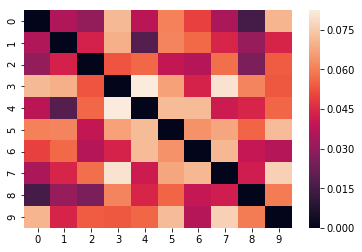

In [8]:
sns.heatmap(kappa_df)

#### Cluster the results

In [128]:
from sklearn.cluster import AgglomerativeClustering
clustering = AgglomerativeClustering(n_clusters=3, affinity='precomputed', linkage='complete').fit_predict(kappa_df)
#np.unique(clustering.labels_, return_counts=True)

In [130]:
x = experiments
y = clustering

In [131]:
import matplotlib.pyplot as plt

import ema_workbench.analysis.cart as cart
from ema_workbench import ema_logging, load_results
from ema_workbench.analysis import (cart, RuleInductionType)

ema_logging.log_to_stderr(level=ema_logging.INFO)

<Logger EMA (DEBUG)>

In [132]:
cart_alg = cart.CART(x, y, mass_min = 0.5, mode = RuleInductionType.CLASSIFICATION)

In [133]:
cart_alg.build_tree()

In [134]:
cart_alg.stats_to_dataframe()

,box_composition,gini,mass,res dim
box 1,"[1, 3, 1]",0.56,0.5,1
box 2,"[5, 0, 0]",0.00,0.5,1


In [135]:
cart_alg.boxes_to_dataframe()

box 1      box 2    
               min  max   min max
TigrisXLfile     1  2.5   2.5   4

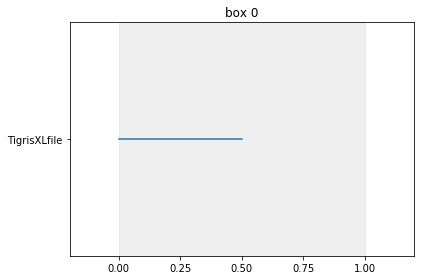

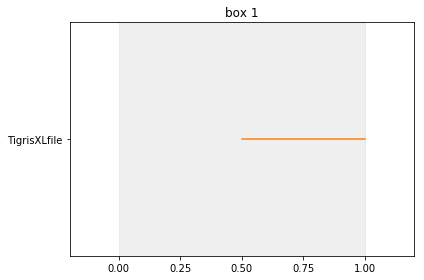

In [136]:
cart_alg.show_boxes(together=False)
plt.show()

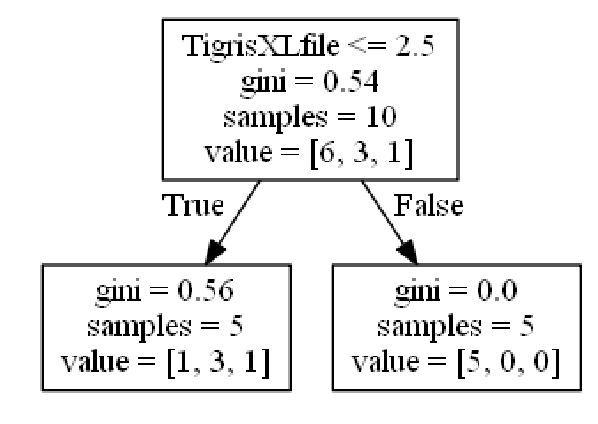

In [139]:
tree = cart_alg.show_tree()
fig = plt.gcf()
fig.set_size_inches(10,10)
plt.show()